In [6]:
import pathlib
import imageio
import numpy as np

training_paths = pathlib.Path('./stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

C:\Users\com\AppData\Local\Temp\ipykernel_1228\420900461.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(str(im_path))


In [9]:
print('Original image shape: {}'.format(im.shape))


# 이미지를 회색조 형식으로 강제변환(회색조 형식이 아닌 경우)
from skimage.color import rgb2gray
if im.shape[2] == 4:
    # 투명도 채널을 제외한 RGB 채널만 선택
    im = im[:, :, :3]

im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (520, 696, 4)
New image shape: (520, 696)


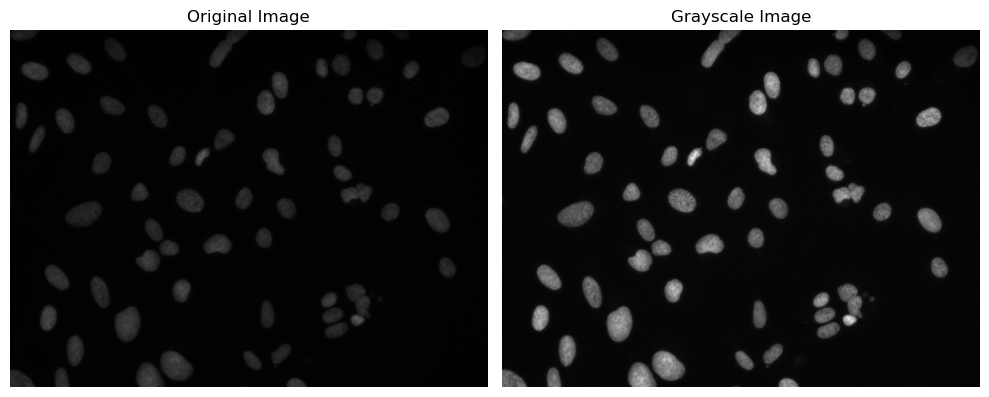

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

## background 제거
이미지에 관심개체와 배경이라는 두 가지 클래스가 있다고 가정.

데이터의 강도가 이봉분포에 속할 것으로 예상. 최상의 분리 값을 찾았다면 배경 데이터를 '마스킹'한 다음 남은 개체 수를 간단히 계산할 수 있음.

임계값을 찾을 수 있는 'dumbest'한 방법은 평균이나 중앙값과 같은 간단한 설명 통계를 사용하는 것.

그러나 'Otsu'와 같은 다른 방법도 존재함. 이미지를 이중 모드 분포로 모델링하고 최적의 분리 값을 찾기 때문에 유용

In [15]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

if np.sum(mask == 0) < np.sum(mask == 1):
    mask = np.where(mask, 0, 1)

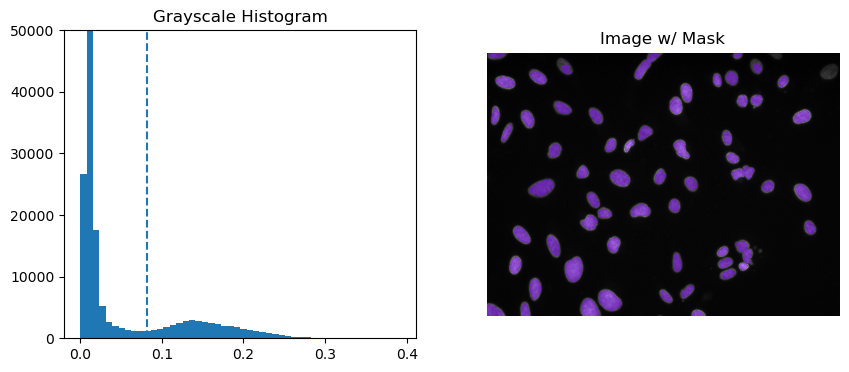

In [16]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

## 각 객체에 대한 개별 마스크 파생
각 핵마다 별도의 마스크가 필요함. 이를 수행할 수 있는 한 가지 방법은 마스크에서 연결된 모든 객체를 찾고 ndimage.label을 사용해 각 객체에 번호를 할당하는 것임.

그 다음 label_id를 반복해 목록과 같은 반복 가능 항목에 추가할 수 있음.

In [17]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []

for label_num in range(1, nlabels + 1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


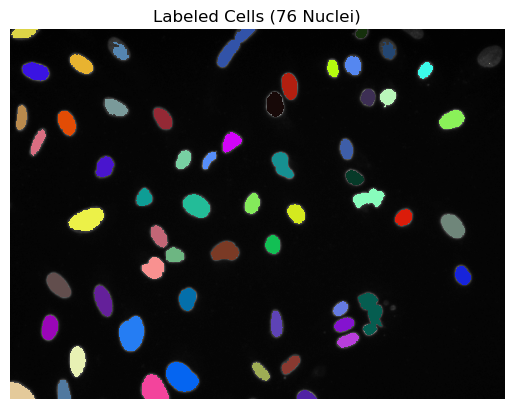

In [19]:
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256, 3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

ndimage.find_objects를 사용하면 마스크를 반복하면서 추가 처리 단계를 적용하기 위해 발견된 개별 핵을 확대할 수 있습니다. 

find_objects는 이미지의 라벨이 지정된 각 객체에 대한 좌표 범위 목록을 반환합니다.

In [21]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]

    if np.product(cell.shape) < 10:
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels == label_ind+1, 0, mask)

labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


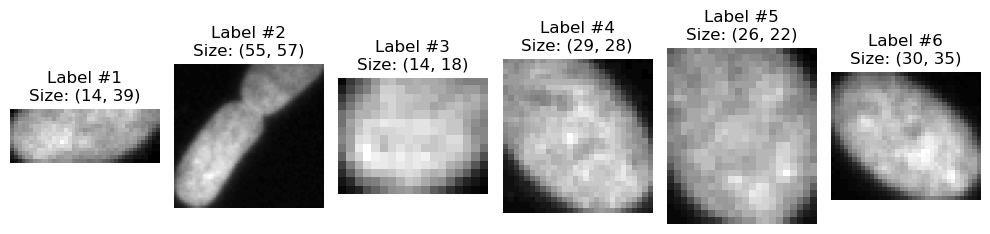

In [22]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

Label #2는 인접 셀 문제가 있음. 즉 두 셀이 동일한 개체의 일부로 간주됨.

여기서 할 수 있는 한 가지는 마스크를 축소해 셀 간의 차이점을 'open up'할 수 있는지 확인하는 것. 이를 mask erosion이라고 함.

그런 다음 원래 비율을 복구하기 위해 다시 확장할 수 있음.

In [26]:
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations = 8)

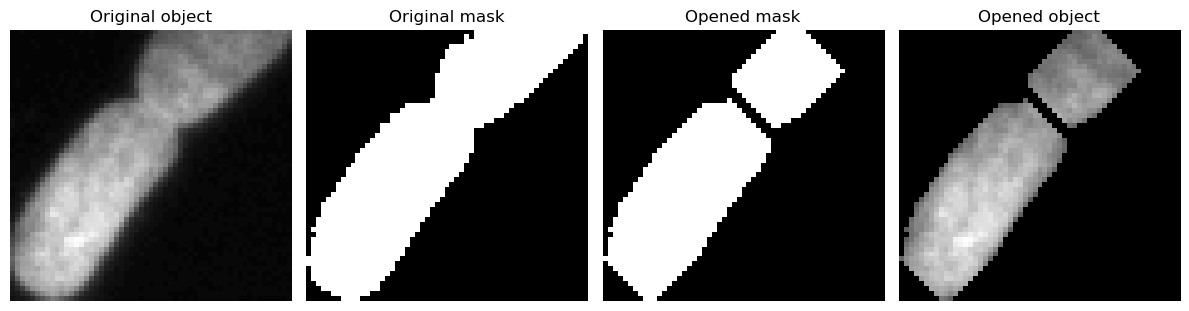

In [27]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## 각 레이블된 객체를 Run Line Encoding으로 변환
마지막으로 각 label_mask를 "run line encoded" 문자열로 인코딩 해야함.

기본적으로 배열을 살펴보고 마스크의 일부인 픽셀을 찾으면 이를 인덱싱하고 후속 픽셀이 마스크의 일부인지를 계산

새로운 픽셀 시작점을 볼 때마다 이것을 반복함.

In [23]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if(b > prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


## 하나의 functin으로 결합
"dumb"한 방식으로 이미지를 처리하는 기본 단계를 사펴봤으므로 모든 단계를 단일 함수로 결합할 수 있음.

이 함수는 이미지 경로를 가져와 각 마스크에 대한 RLE문자열이 포함된 데이터 프레임을 생성함.

또한 데이터 세트의 모든 이미지에 대해 단일 DataFrame을 생성하는 wrapper 함수를 만듬

In [24]:
import pandas as pd

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [25]:
testing = pathlib.Path('./stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)